In [458]:
import pandas as pd

# reading cleaned data
data = pd.read_csv('./classification_data_cleaned.csv')

print("Data shape : ", data.shape)

Data shape :  (4024, 16)


In [459]:
# drop target variables
x = data.drop(columns=["Mortality_Status"])
y = data["Mortality_Status"]

In [460]:
print("Features used for classification:")
for col in x.columns:
    print(col)

print("Shape of x (features):", x.shape)
print("Shape of y (target):", y.shape)


Features used for classification:
Age
6th_Stage
Differentiated
Grade
A_Stage
Tumor_Size
Regional_Node_Examined
Reginol_Node_Positive
T_Stage_T2
T_Stage_T3
T_Stage_T4
N_Stage_N2
N_Stage_N3
Estrogen_Status_Positive
Progesterone_Status_Positive
Shape of x (features): (4024, 15)
Shape of y (target): (4024,)


In [461]:
from sklearn.model_selection import train_test_split

# split 80% for trainning , 20% for testing
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, stratify=y, random_state=42
)

print("------- Classification data split complete -------")
print(f"Training set: {x_train.shape[0]} samples")
print(f"Testing set: {x_test.shape[0]} samples")

------- Classification data split complete -------
Training set: 2816 samples
Testing set: 1208 samples


In [462]:
x_train = pd.get_dummies(x_train, columns=['6th_Stage', 'Differentiated', 'A_Stage'], drop_first=True)
x_test = pd.get_dummies(x_test, columns=['6th_Stage', 'Differentiated', 'A_Stage'], drop_first=True)

# Ensure train and test have same columns
x_train, x_test = x_train.align(x_test, join='left', axis=1, fill_value=0)


In [463]:
# verifying the coloumns are numeric
print(x_train.select_dtypes(include=['object', 'string']).columns)  # should return empty Index


Index([], dtype='object')


In [464]:
# dropping missing coloumns
X_train = x_train.dropna()
y_train = y_train[x_train.index]  # Keep alignment

X_test = x_test.dropna()
y_test = y_test[x_test.index]


In [465]:
# logistic regression
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=5000)
lr_model.fit(x_train, y_train)


LogisticRegression(max_iter=5000)

In [466]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(x_train, y_train)


KNeighborsClassifier()

In [467]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(x_train, y_train)


GaussianNB()

In [468]:
# re-usable confusion metrics function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, X_test, y_test, model_name="Model", cmap='Blues'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=cmap)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


In [469]:
# re-usable roc-curve function
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# custom ROC Curve 
def plot_custom_roc_curve(model, x_test, y_test, model_name="Model"):
    y_probs = model.predict_proba(x_test)[:, 1]
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.figure(figsize=(6, 4))
    plt.plot(false_positive_rate, true_positive_rate, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


In [470]:
# re-useable function for classification report
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report

def print_classification_report(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    print(f"\nClassification Report - {model_name}")
    print(classification_report(y_test, y_pred))



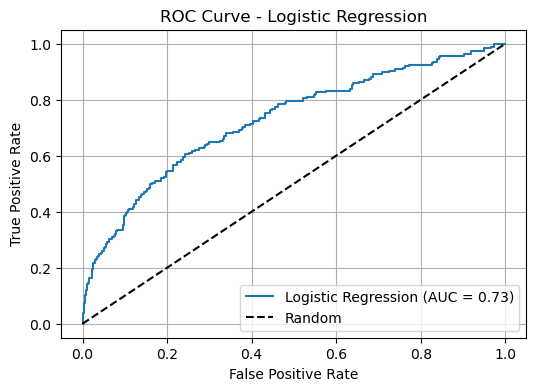

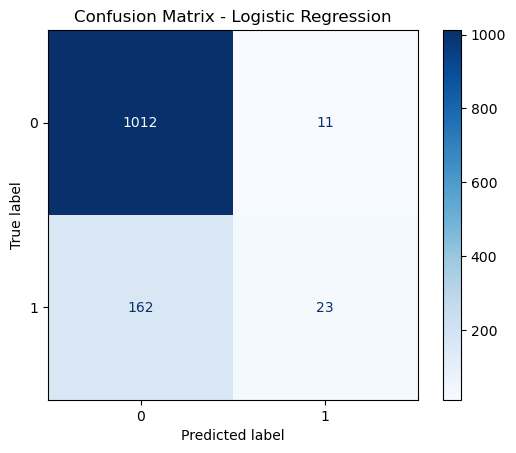


Classification Report - Logistic Regression
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1023
           1       0.68      0.12      0.21       185

    accuracy                           0.86      1208
   macro avg       0.77      0.56      0.57      1208
weighted avg       0.83      0.86      0.81      1208



In [471]:
# Evaluate all models - Logistic Regression
plot_custom_roc_curve(lr_model, x_test, y_test, "Logistic Regression")
plot_confusion_matrix(lr_model, X_test, y_test, model_name="Logistic Regression")
print_classification_report(lr_model, X_test, y_test, model_name="Logistic Regression")






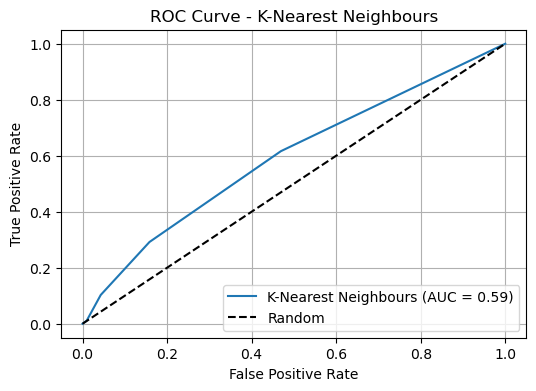

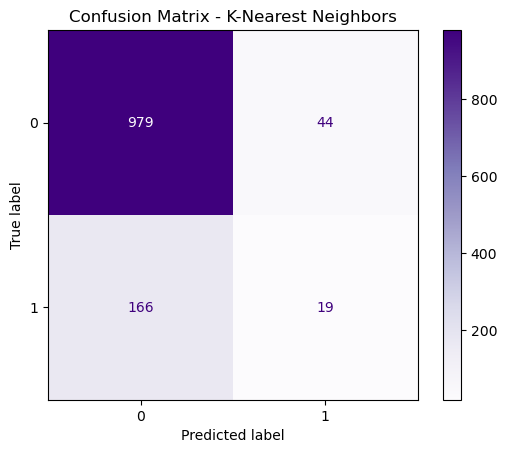


Classification Report - K-Nearest Neighbors
              precision    recall  f1-score   support

           0       0.86      0.96      0.90      1023
           1       0.30      0.10      0.15       185

    accuracy                           0.83      1208
   macro avg       0.58      0.53      0.53      1208
weighted avg       0.77      0.83      0.79      1208



In [472]:
# Evaluate all models - KNN 
plot_custom_roc_curve(knn_model, x_test, y_test, "K-Nearest Neighbours")
plot_confusion_matrix(knn_model, X_test, y_test, model_name="K-Nearest Neighbors", cmap='Purples')
print_classification_report(knn_model, X_test, y_test, model_name="K-Nearest Neighbors")




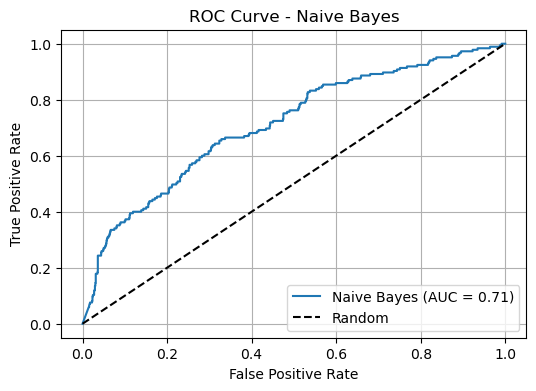

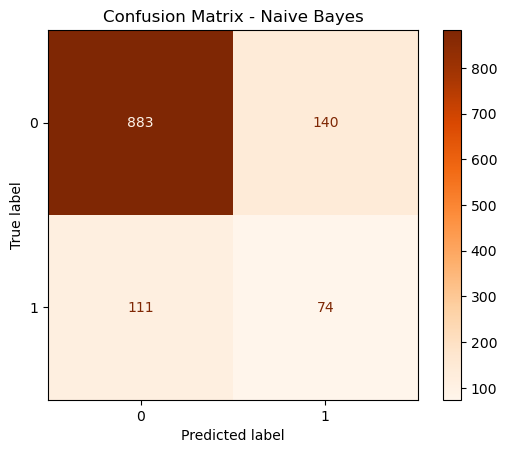


Classification Report - Naive Bayes
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1023
           1       0.35      0.40      0.37       185

    accuracy                           0.79      1208
   macro avg       0.62      0.63      0.62      1208
weighted avg       0.81      0.79      0.80      1208



In [473]:
# Evaluate all models - Naive Bayes
plot_custom_roc_curve(nb_model, x_test, y_test, "Naive Bayes")
plot_confusion_matrix(nb_model, X_test, y_test, model_name="Naive Bayes", cmap='Oranges')
print_classification_report(nb_model, X_test, y_test, model_name="Naive Bayes")






In [474]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
import pandas as pd

def evaluate_all_metrics(model, x_test, y_test, model_name="Model"):
    
    y_pred = model.predict(x_test)

    # If binary classification, get predicted probabilities for AUC-ROC
    if len(set(y_test)) == 2:
        y_proba = model.predict_proba(x_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    else:
        auc = 'N/A'  # AUC-ROC is for binary classification

    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred, average='weighted'),
        "AUC-ROC": auc
    }


In [475]:
# Collect results
results = []

results.append(evaluate_all_metrics(lr_model, x_test, y_test, "Logistic Regression"))
results.append(evaluate_all_metrics(nb_model, x_test, y_test, "Naive Bayes"))
results.append(evaluate_all_metrics(knn_model, x_test, y_test, "K-Nearest Neighbors"))

# Display as a DataFrame
metrics_df = pd.DataFrame(results)
print(metrics_df)


                 Model  Accuracy  Precision    Recall  F1-Score   AUC-ROC
0  Logistic Regression  0.856788   0.833596  0.856788  0.812337  0.726443
1          Naive Bayes  0.792219   0.805243  0.792219  0.798276  0.711337
2  K-Nearest Neighbors  0.826159   0.770266  0.826159  0.788291  0.594777


In [476]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # liblinear supports both l1 and l2
}


In [477]:
log_reg = LogisticRegression()

grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, 
                           scoring='f1_weighted', cv=5, verbose=1)

grid_search.fit(x_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='f1_weighted', verbose=1)

In [478]:
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [479]:
from sklearn.metrics import classification_report

y_pred = best_model.predict(x_test)
print("Classification Report (Tuned Logistic Regression):")
print(classification_report(y_test, y_pred))


Classification Report (Tuned Logistic Regression):
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1023
           1       0.69      0.13      0.22       185

    accuracy                           0.86      1208
   macro avg       0.77      0.56      0.57      1208
weighted avg       0.84      0.86      0.81      1208



Confusion Matrix:
[[1012   11]
 [ 161   24]]


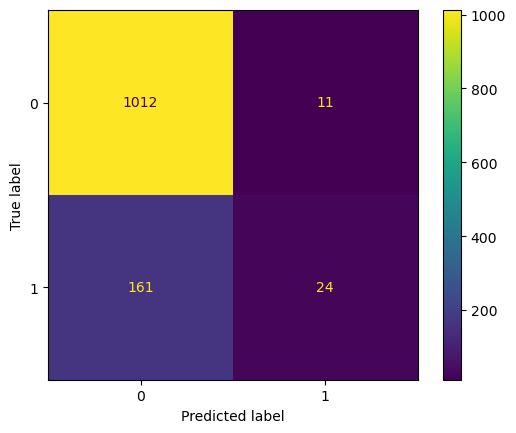

In [480]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optional: Display it visually
confusion_metrix_visual = ConfusionMatrixDisplay(confusion_matrix=cm)
confusion_metrix_visual.plot()
